In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import yfinance as yf
import ta
from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
should_load_new_data = False
SEED = 42

output_dir = Path('../data/processed/random_forest')

# Explore what data we can get

In [5]:
stock = yf.Ticker("NVDA")

In [8]:
stock.history(period="1mo").tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-02-24 00:00:00-05:00,136.559998,138.589996,130.080002,130.279999,251381100,0.0,0.0
2025-02-25 00:00:00-05:00,129.979996,130.199997,124.440002,126.629997,271428700,0.0,0.0
2025-02-26 00:00:00-05:00,129.990005,133.729996,128.490005,131.279999,322553800,0.0,0.0
2025-02-27 00:00:00-05:00,135.000000,135.009995,120.010002,120.150002,443175800,0.0,0.0
2025-02-28 00:00:00-05:00,118.019997,125.089996,116.400002,124.919998,388160100,0.0,0.0


Everyday stock prices, include:
- Open, high, low, close: obvious
- Volume: Amount of stock exchanged
- Dividends: Paid on that date if exists, else 0
- Stock splits: Is when a company increases the number of shares outstanding by dividing its existing shares. The price of each share decreases, but the total shareholder value remains the same.

For example:
🔹 2-for-1 split: If you have 1 share of stock worth 200, after the split, you will have 2 shares worth 100 each.

So these are the columns we are gonna try to predict

In [5]:
stock.option_chain(stock.options[0]).calls.tail()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
54,MSFT250307C00525000,2025-02-07 17:06:29+00:00,525.0,0.03,0.0,0.21,0.0,0.0,1.0,4,0.875001,False,REGULAR,USD
55,MSFT250307C00530000,2025-02-27 17:58:01+00:00,530.0,0.01,0.0,0.21,0.0,0.0,6.0,34,0.900392,False,REGULAR,USD
56,MSFT250307C00540000,2025-02-14 14:30:10+00:00,540.0,0.02,0.0,0.02,0.0,0.0,10.0,26,0.765627,False,REGULAR,USD
57,MSFT250307C00550000,2025-01-30 20:57:35+00:00,550.0,0.05,0.0,0.21,0.0,0.0,NaN,19,1.000005,False,REGULAR,USD
58,MSFT250307C00560000,2025-01-30 20:39:00+00:00,560.0,0.04,0.0,0.21,0.0,0.0,NaN,22,1.048833,False,REGULAR,USD


In [45]:
stock.balance_sheet.head()

,2025-01-31,2024-01-31,2023-01-31,2022-01-31,2021-01-31
Treasury Shares Number,NaN,NaN,NaN,NaN,13800000000.0
Ordinary Shares Number,24477000000.0,24640000000.0,24661365720.0,25060000000.0,NaN
Share Issued,24477000000.0,24640000000.0,24661365720.0,25060000000.0,NaN
Net Debt,NaN,2429000000.0,7564000000.0,8956000000.0,6116000000.0
Total Debt,10270000000.0,11056000000.0,12031000000.0,11831000000.0,NaN


In [47]:
stock.balance_sheet.shape

(86, 5)

In [8]:
stock.balance_sheet.index

Index(['Ordinary Shares Number', 'Share Issued', 'Net Debt', 'Total Debt',
       'Tangible Book Value', 'Invested Capital', 'Working Capital',
       'Net Tangible Assets', 'Capital Lease Obligations',
       'Common Stock Equity', 'Total Capitalization',
       'Total Equity Gross Minority Interest', 'Stockholders Equity',
       'Gains Losses Not Affecting Retained Earnings',
       'Other Equity Adjustments', 'Retained Earnings', 'Capital Stock',
       'Common Stock', 'Total Liabilities Net Minority Interest',
       'Total Non Current Liabilities Net Minority Interest',
       'Other Non Current Liabilities', 'Tradeand Other Payables Non Current',
       'Non Current Deferred Liabilities', 'Non Current Deferred Revenue',
       'Non Current Deferred Taxes Liabilities',
       'Long Term Debt And Capital Lease Obligation',
       'Long Term Capital Lease Obligation', 'Long Term Debt',
       'Current Liabilities', 'Other Current Liabilities',
       'Current Deferred Liabilities',

Those yearly report should be useful

In [50]:
stock.quarterly_income_stmt.head()

,2025-01-31,2024-10-31,2024-07-31,2024-04-30,2024-01-31,2023-10-31,2023-07-31
Tax Effect Of Unusual Items,0.0,0.0,0.0,0.0,0.0,NaN,NaN
Tax Rate For Calcs,0.123964,0.135,0.136,0.139,0.129094,NaN,NaN
Normalized EBITDA,25821000000.0,22855000000.0,19708000000.0,17753000000.0,14556000000.0,NaN,NaN
Total Unusual Items,NaN,NaN,NaN,NaN,0.0,0.0,0.0
Total Unusual Items Excluding Goodwill,NaN,NaN,NaN,NaN,0.0,0.0,0.0


In [51]:
stock.quarterly_income_stmt.shape

(43, 7)

In [11]:
stock.quarterly_income_stmt.index

Index(['Tax Effect Of Unusual Items', 'Tax Rate For Calcs',
       'Normalized EBITDA', 'Total Unusual Items',
       'Total Unusual Items Excluding Goodwill',
       'Net Income From Continuing Operation Net Minority Interest',
       'Reconciled Depreciation', 'Reconciled Cost Of Revenue', 'EBITDA',
       'EBIT', 'Net Interest Income', 'Interest Expense', 'Interest Income',
       'Normalized Income',
       'Net Income From Continuing And Discontinued Operation',
       'Total Expenses', 'Total Operating Income As Reported',
       'Diluted Average Shares', 'Basic Average Shares', 'Diluted EPS',
       'Basic EPS', 'Diluted NI Availto Com Stockholders',
       'Net Income Common Stockholders', 'Net Income',
       'Net Income Including Noncontrolling Interests',
       'Net Income Continuous Operations', 'Tax Provision', 'Pretax Income',
       'Other Income Expense', 'Other Non Operating Income Expenses',
       'Special Income Charges', 'Write Off', 'Gain On Sale Of Security',
  

In [12]:
stock.calendar

{'Dividend Date': datetime.date(2025, 3, 13),
 'Ex-Dividend Date': datetime.date(2025, 2, 20),
 'Earnings Date': [datetime.date(2025, 4, 24), datetime.date(2025, 4, 29)],
 'Earnings High': 3.56,
 'Earnings Low': 3.16,
 'Earnings Average': 3.22615,
 'Revenue High': 69897682310,
 'Revenue Low': 67140000000,
 'Revenue Average': 68534440260}

- Dividend Date: Ngày chi trả cổ tức tiếp theo.
- Ex-Dividend Date: Ngày giao dịch không hưởng quyền cổ tức.
- Earnings Date: Khoảng thời gian công ty dự kiến công bố báo cáo thu nhập: Đây là thời điểm quan trọng vì giá cổ phiếu thường biến động mạnh sau khi công ty công bố lợi nhuận.

- Earnings High: Dự báo EPS (Lợi nhuận trên mỗi cổ phiếu) cao nhất từ các nhà phân tích.
- Earnings Low: Dự báo EPS thấp nhất.
- Earnings Average: Trung bình dự báo EPS.

- Revenue High: Doanh thu dự kiến cao nhất.
- Revenue Low: Doanh thu dự kiến thấp nhất.
- Revenue Average: Trung bình dự báo doanh thu.

In [49]:
# stock.info

In [9]:
stock.analyst_price_targets

{'current': 396.99,
 'high': 650.0,
 'low': 420.0,
 'mean': 508.051,
 'median': 500.0}

- current: Giá hiện tại của cổ phiếu trên thị trường.
- high: Mức giá cao nhất mà một số nhà phân tích dự đoán cổ phiếu có thể đạt được.
- low: Mức giá thấp nhất mà một số nhà phân tích dự đoán.
- mean: Mức giá trung bình từ dự báo của nhiều nhà phân tích.
- median: Mức giá trung vị trong dự báo của các nhà phân tích.
6 - 12 tháng trong tương lai

In [13]:
stock.eps_trend

,current,7daysAgo,30daysAgo,60daysAgo,90daysAgo
period,,,,,
0q,3.21293,3.21472,3.16529,3.17325,3.17383
+1q,3.33131,3.33346,3.29005,3.29549,3.29340
0y,13.15656,13.15656,13.02874,13.04388,13.08535
+1y,15.07137,15.07137,15.06393,15.08038,15.10941


# Load data

## Company information

In [4]:
tickers = ["MSFT", "AAPL", "TSLA", "GOOGL", "AMZN", "NVDA"]

In [4]:
if should_load_new_data:
    all_info_data = []
    
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        balance_sheet = stock.balance_sheet
        years = balance_sheet.columns = balance_sheet.columns.year
        if len(years) > 4:
            years = years[1:]                                                # Take 4 nearest years
    
        data = {"Ticker": ticker}
        for feature in balance_sheet.index:
            for year in years:
                data[f"{feature}_{max(years) - year}ya"] = balance_sheet.at[feature, year]
    
        df = pd.DataFrame([data])
        
        all_info_data.append(df)
    
    final_info_df = pd.concat(all_info_data, ignore_index=True)
    final_info_df.tail()

## Time series

In [6]:
parquet_file = Path("../data/raw/stock_data_till_Feb.parquet")

if should_load_new_data:
    all_ts_data = []
    
    for ticker in tqdm(tickers, desc="Loading ts data"):
        stock = yf.Ticker(ticker)
        df = stock.history(start="2014-03-01", end="2024-03-01")

        df.index = df.index.date
        
        if df.empty:
            print(f"Lỗi: Không có dữ liệu cho {ticker}")
            continue
        
        df["Ticker"] = ticker

        # Thêm các chỉ số kỹ thuật
        df["SMA_10"] = ta.trend.sma_indicator(df["Close"], window=10)
        df["SMA_30"] = ta.trend.sma_indicator(df["Close"], window=30)
        df["SMA_60"] = ta.trend.sma_indicator(df["Close"], window=60)
        
        df["RSI_10"] = ta.momentum.rsi(df["Close"], window=10)
        df["RSI_30"] = ta.momentum.rsi(df["Close"], window=30)
        df["RSI_60"] = ta.momentum.rsi(df["Close"], window=60)
        
        df["MACD"] = ta.trend.macd(df["Close"])
        df["MACD_signal"] = ta.trend.macd_signal(df["Close"])
        df["ATR_10"] = ta.volatility.average_true_range(df["High"], df["Low"], df["Close"], window=10)  # ATR (volatility)
        df["Bollinger_Upper"], df["Bollinger_Lower"] = ta.volatility.bollinger_hband(df["Close"]), ta.volatility.bollinger_lband(df["Close"])  # Bollinger Bands
        
        df["CCI_10"] = ta.trend.cci(df["High"], df["Low"], df["Close"], window=10)
        df["CCI_30"] = ta.trend.cci(df["High"], df["Low"], df["Close"], window=30)
        df["CCI_60"] = ta.trend.cci(df["High"], df["Low"], df["Close"], window=60)
        
        df["DX_10"] = ta.trend.dpo(df["Close"], window=10)
        df["DX_30"] = ta.trend.dpo(df["Close"], window=30)
        df["DX_60"] = ta.trend.dpo(df["Close"], window=60)
        
        df["ADX_10"] = ta.trend.adx(df["High"], df["Low"], df["Close"], window=10)
        df["ADX_30"] = ta.trend.adx(df["High"], df["Low"], df["Close"], window=30)
        df["ADX_60"] = ta.trend.adx(df["High"], df["Low"], df["Close"], window=60)

        df["Returns"] = df["Close"].pct_change()
        mean_return = df["Returns"].mean()
        std_return = df["Returns"].std()
        df["Turbulence"] = np.abs((df["Returns"] - mean_return) / std_return)

        # Thêm giá Open/High/Low/Close của 5 ngày trước
        for lag in range(1, 6):
            df[f"Open_lag_{lag}"] = df["Open"].shift(lag)
            df[f"High_lag_{lag}"] = df["High"].shift(lag)
            df[f"Low_lag_{lag}"] = df["Low"].shift(lag)
            df[f"Close_lag_{lag}"] = df["Close"].shift(lag)

        # Target
        df["next_close"] = df["Close"].shift(-1)
        df["next_returns"] = df["Returns"].shift(-1)
        df["increase_decrease"] = (df["next_close"] > df["Close"]).astype(int)

        # df.index = df.index.tz_convert(None)
        df = df.groupby("Ticker").apply(lambda x: x.iloc[60:-1])
        df = df.reset_index(level="Ticker", drop=True)

        all_ts_data.append(df)
    
    final_df = pd.concat(all_ts_data)
    
    final_df.to_parquet(parquet_file, engine="pyarrow")
    
    print(f"Data saved to {parquet_file.name}")

    # should_load_new_data = False

In [7]:
ts_df = pd.read_parquet(parquet_file)
ts_df.shape

(14736, 53)

In [8]:
# ts_df[["Close", "Returns", "next_close", "next_returns"]]
ts_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,SMA_10,SMA_30,...,High_lag_4,Low_lag_4,Close_lag_4,Open_lag_5,High_lag_5,Low_lag_5,Close_lag_5,next_close,next_returns,increase_decrease
2014-05-28,33.971182,34.013498,33.700361,33.861160,25711500,0.0,0.0,MSFT,33.841697,33.656903,...,34.148914,33.632663,34.148914,33.581886,33.801927,33.395695,33.581886,34.140450,0.008248,1
2014-05-29,33.979650,34.148911,33.776533,34.140450,19888200,0.0,0.0,MSFT,33.850159,33.681403,...,34.148896,33.725738,33.937317,33.683440,34.148914,33.632663,34.148914,34.648243,0.014874,1
2014-05-30,34.233549,34.673635,34.064285,34.648243,34567600,0.0,0.0,MSFT,33.963567,33.704620,...,34.165822,33.852686,33.954243,34.098119,34.148896,33.725738,33.937317,34.521297,-0.003664,0
2014-06-02,34.656708,34.775192,34.428202,34.521297,18504300,0.0,0.0,MSFT,34.044814,33.734532,...,34.072742,33.691902,34.013500,34.165822,34.165822,33.852686,33.954243,34.098137,-0.012258,0
2014-06-03,34.360493,34.428200,34.064283,34.098137,18068900,0.0,0.0,MSFT,34.090515,33.752299,...,34.013498,33.700361,33.861160,34.072742,34.072742,33.691902,34.013500,34.123524,0.000745,1


# Analyze the dataset

## Helper function

In [9]:
def calculate_stats(data, columns):
    if isinstance(columns, str):
        columns = [columns]

    stats = []
    for col in columns:
        if data[col].dtype in ['object', 'category']:
            counts = data[col].value_counts(dropna=False, sort=False)
            percents = data[col].value_counts(normalize=True, dropna=False, sort=False) * 100
            formatted = counts.astype(str) + ' (' + percents.round(2).astype(str) + '%)'
            stats_col = pd.DataFrame({'count (%)': formatted})
            stats.append(stats_col)
        else:
            stats_col = data[col].describe().to_frame().transpose()
            stats_col['missing'] = data[col].isnull().sum()
            stats_col.index.name = col
            stats.append(stats_col)

    return pd.concat(stats, axis=0)

## Overview

In [10]:
ts_df = pd.get_dummies(ts_df, columns=['Ticker'])

target_cols = ['next_close', 'next_returns', 'increase_decrease']
num_cols = ts_df.select_dtypes(include=["number"]).columns.difference(target_cols)
cat_cols = ts_df.select_dtypes(exclude=["number"]).columns

num_cols, cat_cols

(Index(['ADX_10', 'ADX_30', 'ADX_60', 'ATR_10', 'Bollinger_Lower',
        'Bollinger_Upper', 'CCI_10', 'CCI_30', 'CCI_60', 'Close', 'Close_lag_1',
        'Close_lag_2', 'Close_lag_3', 'Close_lag_4', 'Close_lag_5', 'DX_10',
        'DX_30', 'DX_60', 'Dividends', 'High', 'High_lag_1', 'High_lag_2',
        'High_lag_3', 'High_lag_4', 'High_lag_5', 'Low', 'Low_lag_1',
        'Low_lag_2', 'Low_lag_3', 'Low_lag_4', 'Low_lag_5', 'MACD',
        'MACD_signal', 'Open', 'Open_lag_1', 'Open_lag_2', 'Open_lag_3',
        'Open_lag_4', 'Open_lag_5', 'RSI_10', 'RSI_30', 'RSI_60', 'Returns',
        'SMA_10', 'SMA_30', 'SMA_60', 'Stock Splits', 'Turbulence', 'Volume'],
       dtype='object'),
 Index(['Ticker_AAPL', 'Ticker_AMZN', 'Ticker_GOOGL', 'Ticker_MSFT',
        'Ticker_NVDA', 'Ticker_TSLA'],
       dtype='object'))

In [11]:
calculate_stats(ts_df, num_cols)

,count,mean,std,min,25%,50%,75%,max,missing
ADX_10,14736.0,2.913460e+01,1.106229e+01,6.929330e+00,2.086196e+01,2.701995e+01,3.538645e+01,7.889624e+01,0
ADX_30,14736.0,1.783100e+01,7.076272e+00,5.592261e+00,1.245129e+01,1.639716e+01,2.162743e+01,4.756211e+01,0
ADX_60,14736.0,1.288993e+01,5.527974e+00,0.000000e+00,9.022173e+00,1.195955e+01,1.584782e+01,3.381858e+01,0
ATR_10,14736.0,2.422406e+00,3.164459e+00,7.669061e-03,5.462353e-01,1.055290e+00,3.218676e+00,2.358488e+01,0
Bollinger_Lower,14736.0,7.712443e+01,7.572719e+01,3.884997e-01,2.050720e+01,4.695108e+01,1.198261e+02,3.946904e+02,0
Bollinger_Upper,14736.0,8.894817e+01,8.839674e+01,4.491124e-01,2.392001e+01,5.196278e+01,1.351365e+02,4.384020e+02,0
CCI_10,14736.0,1.974846e+01,1.046961e+02,-3.235209e+02,-6.611732e+01,3.650751e+01,1.021796e+02,3.333333e+02,0
CCI_30,14736.0,3.340859e+01,1.112186e+02,-4.110599e+02,-4.966116e+01,5.029397e+01,1.137397e+02,5.639998e+02,0
CCI_60,14736.0,4.417370e+01,1.109670e+02,-3.849390e+02,-3.720965e+01,6.207159e+01,1.222338e+02,8.517836e+02,0
Close,14736.0,8.372085e+01,8.245336e+01,4.012815e-01,2.224500e+01,4.983875e+01,1.290748e+02,4.165932e+02,0


## Target features

In [12]:
calculate_stats(ts_df, target_cols)

,count,mean,std,min,25%,50%,75%,max,missing
next_close,14736.0,83.793744,82.500859,0.401282,22.257249,49.898712,129.145264,416.593170,0
next_returns,14736.0,0.001411,0.024006,-0.210628,-0.008975,0.001143,0.012112,0.298067,0
increase_decrease,14736.0,0.531080,0.499050,0.000000,0.000000,1.000000,1.000000,1.000000,0


Our task is to predict these 3 columns and see what works best

## Feature importance with random forest

### First let normalize the columns

In [13]:
from sklearn.preprocessing import StandardScaler

price_cols = [
    'Close', 'Close_lag_1', 'Close_lag_2', 'Close_lag_3', 'Close_lag_4', 'Close_lag_5',
    'High', 'High_lag_1', 'High_lag_2', 'High_lag_3', 'High_lag_4', 'High_lag_5',
    'Low', 'Low_lag_1', 'Low_lag_2', 'Low_lag_3', 'Low_lag_4', 'Low_lag_5',
    'Open', 'Open_lag_1', 'Open_lag_2', 'Open_lag_3', 'Open_lag_4', 'Open_lag_5',
    'SMA_10', 'SMA_30', 'SMA_60', 'Volume'
]

scaler = StandardScaler()
ts_df[price_cols] = scaler.fit_transform(ts_df[price_cols])

In [14]:
calculate_stats(ts_df, price_cols)

,count,mean,std,min,25%,50%,75%,max,missing
Close,14736.0,-3.085962e-17,1.000034,-1.010540,-0.745609,-0.410938,0.550075,4.037235,0
Close_lag_1,14736.0,-6.171924e-17,1.000034,-1.010227,-0.745486,-0.410811,0.549900,4.040351,0
Close_lag_2,14736.0,3.085962e-17,1.000034,-1.009910,-0.745203,-0.410676,0.549923,4.043472,0
Close_lag_3,14736.0,-4.628943e-17,1.000034,-1.009592,-0.744854,-0.410670,0.550102,4.046593,0
Close_lag_4,14736.0,4.628943e-17,1.000034,-1.009278,-0.744608,-0.410644,0.550627,4.049747,0
Close_lag_5,14736.0,4.628943e-17,1.000034,-1.008967,-0.744230,-0.410361,0.550659,4.052961,0
High,14736.0,-4.628943e-17,1.000034,-1.008977,-0.744618,-0.413026,0.549252,3.971010,0
High_lag_1,14736.0,3.085962e-17,1.000034,-1.008652,-0.744420,-0.412704,0.548932,3.974027,0
High_lag_2,14736.0,1.080087e-16,1.000034,-1.008324,-0.744043,-0.412570,0.549053,3.977049,0
High_lag_3,14736.0,-6.171924e-17,1.000034,-1.008001,-0.743837,-0.412592,0.548943,3.980119,0


In [15]:
# ts_df['log_next_close'] = np.log1p(ts_df['next_close'])

### Predict next close

In [16]:
X = ts_df[list(num_cols) + list(cat_cols)]
y = ts_df['next_close']

X.shape, y.shape

((14736, 55), (14736,))

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# param_grid = {
#     "n_estimators": [43, 45, 47, 49],  # Số cây
#     "max_depth": [20, 21, 22, None],  # Độ sâu của cây
#     "min_samples_split": [4, 5, 6],  # Số mẫu tối thiểu để tách nhánh
#     "min_samples_leaf": [8, 9, 10],  # Số mẫu tối thiểu ở lá
#     "max_features": [None],  # Số lượng feature khi tách nhánh
#     "bootstrap": [True],  # Có dùng bootstrap không
# }

params = {
    'n_estimators': 47, 
    'min_samples_split': 5, 
    'min_samples_leaf': 8, 
    'max_features': None, 
    'max_depth': 22, 
    'bootstrap': True,
    'random_state': SEED
}

# random_search = RandomizedSearchCV(
#     rf, param_grid, n_iter=20,
#     scoring="neg_mean_squared_error",
#     cv=5, verbose=1, n_jobs=2, random_state=SEED
# )

rf = RandomForestRegressor(**params)
rf.fit(X, y)

# print("Best Parameters:", random_search.best_params_)
# print("Best Score:", np.sqrt(-random_search.best_score_))

RandomForestRegressor(max_depth=22, max_features=None, min_samples_leaf=8,
                      min_samples_split=5, n_estimators=47, random_state=42)

No normalize: 4.392984617930829 
{'n_estimators': 47, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': None, 'max_depth': 22, 'bootstrap': True}
Normalize: 4.4006899230027035 
{'n_estimators': 45, 'min_samples_split': 5, 'min_samples_leaf': 9, 'max_features': None, 'max_depth': 21, 'bootstrap': True}

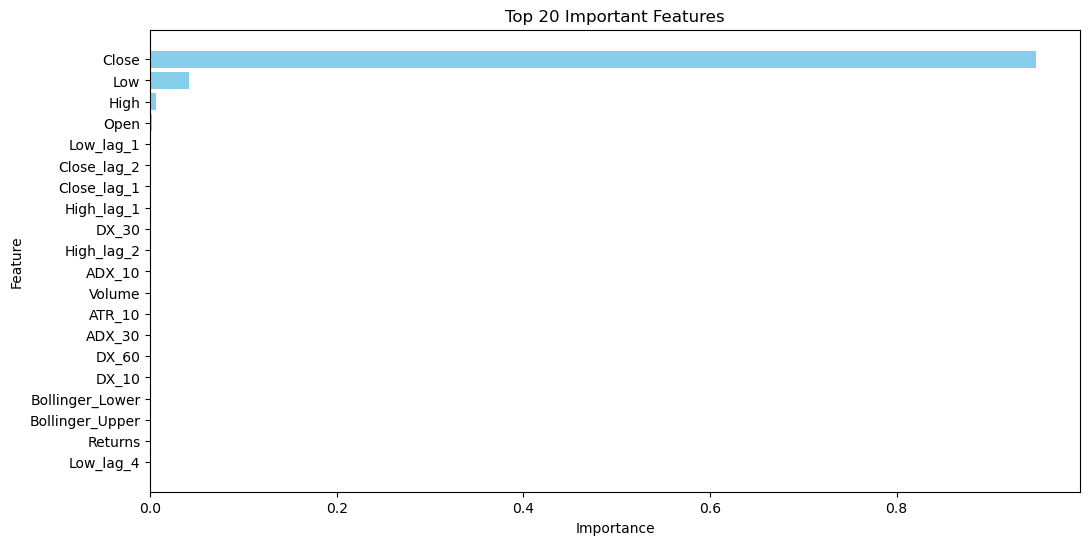

In [35]:
feature_importance = rf.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(importance_df['Feature'][:20], importance_df['Importance'][:20], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Important Features')
plt.gca().invert_yaxis()
plt.show()

🔍 Insights from Feature Importance  

- **Close is the most important feature ($0.949$)**  
  - This is expected since the closing price strongly influences the next day's price. However, its dominance over other features might indicate a **dominance effect**.  

- **Followed by Low, High, and Open**  
  - These features are also relevant as they have a direct relationship with the closing price.  

- **Other features contribute almost nothing**  
  - Technical indicators (SMA, Volume, etc.) seem to have minimal impact. This suggests:  
    - Removing unimportant features to simplify the model.  
    - Trying alternative models like XGBoost or LSTM, which might capture time dependencies better.  

In [37]:
importance_df.to_csv(output_dir/"next_close_fi", index=False)

### Predict next returns

In [18]:
y = ts_df['next_returns']

X.shape, y.shape

((14736, 55), (14736,))

In [21]:
# param_grid = {
#     "n_estimators": [43, 45, 47, 49],  # Số cây
#     "max_depth": [20, 21, 22, None],  # Độ sâu của cây
#     "min_samples_split": [4, 5, 6],  # Số mẫu tối thiểu để tách nhánh
#     "min_samples_leaf": [8, 9, 10],  # Số mẫu tối thiểu ở lá
#     "max_features": [None],  # Số lượng feature khi tách nhánh
#     "bootstrap": [True],  # Có dùng bootstrap không
# }

params = {
    'n_estimators': 49, 
    'min_samples_split': 4, 
    'min_samples_leaf': 9, 
    'max_features': None, 
    'max_depth': 21, 
    'bootstrap': True,
    'random_state': SEED,
    'n_jobs': 2
}

# rf = RandomForestRegressor(random_state=SEED, n_jobs=2)
# random_search = RandomizedSearchCV(
#     rf, param_grid, n_iter=20,
#     scoring="neg_mean_squared_error",
#     cv=5, verbose=1, n_jobs=2, random_state=SEED
# )
# random_search.fit(X, y)

rf = RandomForestRegressor(**params)
rf.fit(X, y)

# print("Best Parameters:", random_search.best_params_)
# print("Best Score:", np.sqrt(-random_search.best_score_))

RandomForestRegressor(max_depth=21, max_features=None, min_samples_leaf=9,
                      min_samples_split=4, n_estimators=49, n_jobs=2,
                      random_state=42)

Best Parameters: {'n_estimators': 49, 'min_samples_split': 4, 'min_samples_leaf': 9, 'max_features': None, 'max_depth': 21, 'bootstrap': True}
Best Score: 0.024274302831256107

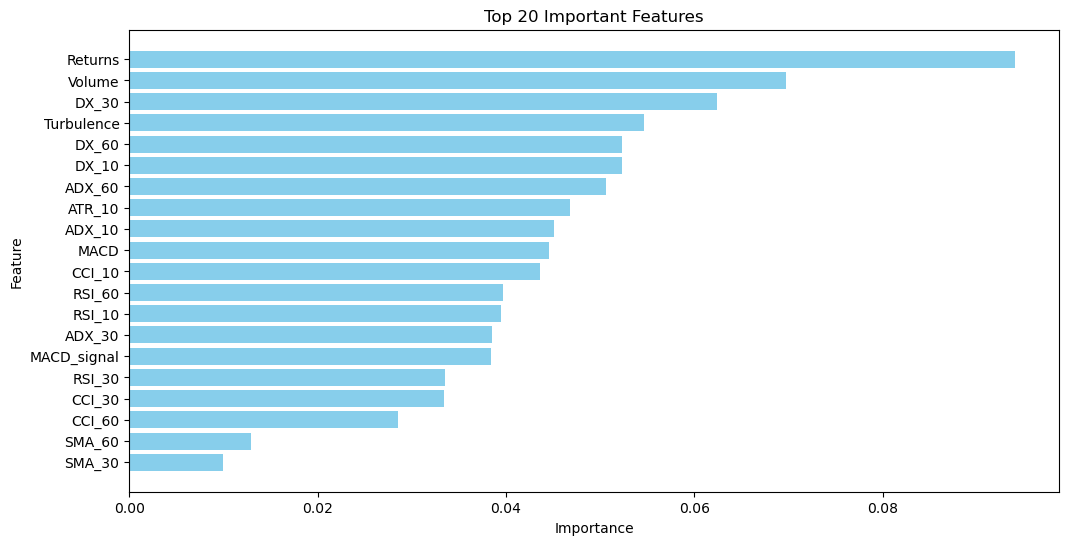

In [22]:
feature_importance = rf.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(importance_df['Feature'][:20], importance_df['Importance'][:20], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Important Features')
plt.gca().invert_yaxis()
plt.show()

importance_df.to_csv(output_dir/"next_returns_fi", index=False)

### Predict increase_decrease

In [23]:
y = ts_df['increase_decrease']

X.shape, y.shape

((14736, 55), (14736,))

In [ ]:
param_grid = {
    "n_estimators": [45, 47, 49, 51],  # Số cây
    "max_depth": [20, 21, 22, None],  # Độ sâu của cây
    "min_samples_split": [4, 5, 6],  # Số mẫu tối thiểu để tách nhánh
    "min_samples_leaf": [8, 9, 10],  # Số mẫu tối thiểu ở lá
    "max_features": ['sqrt', 'log2', None],  # Số lượng feature khi tách nhánh
    'criterion': ['gini', 'entropy'],
}

# params = {
#     'n_estimators': 47, 
#     'min_samples_split': 5, 
#     'min_samples_leaf': 8, 
#     'max_features': None, 
#     'max_depth': 22, 
#     'bootstrap': True,
#     'random_state': SEED
# }

rf = RandomForestClassifier(random_state=SEED, n_jobs=2)
random_search = RandomizedSearchCV(
    rf, param_grid, n_iter=20,
    scoring="neg_mean_squared_error",
    cv=5, verbose=1, n_jobs=2, random_state=SEED
)
random_search.fit(X, y)

# rf = RandomForestRegressor(**params)
# rf.fit(X, y)

print("Best Parameters:", random_search.best_params_)
print("Best Score:", np.sqrt(-random_search.best_score_))

In [ ]:
feature_importance = rf.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(importance_df['Feature'][:20], importance_df['Importance'][:20], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Important Features')
plt.gca().invert_yaxis()
plt.show()

importance_df.to_csv(output_dir/"increase_decrease_fi", index=False)